In [1]:
import cudf
import pandas as pd
import numpy as np
import time

In [2]:
pandas_times = []
cudf_times = []

exps = range(3, 9)

for exp in exps:
    data_length = 10**exp
    print("\ndata length: 1e%d" % exp)

    df = cudf.dataframe.DataFrame()
    df['in1'] = np.arange(data_length, dtype=np.float64)


    def kernel(in1, out):
        for i, x in enumerate(in1):
            out[i] = x * 2.0

    start = time.time()
    df = df.apply_rows(kernel,
                       incols=['in1'],
                       outcols=dict(out=np.float64),
                       kwargs=dict())
    end = time.time()
    print('cuDF time', end-start)
    cudf_times.append(end-start)
    assert(np.isclose(df['in1'].sum()*2.0, df['out'].sum()))


    df = pd.DataFrame()
    df['in1'] = np.arange(data_length, dtype=np.float64)
    start = time.time()
    df['out'] = df.in1.apply(lambda x: x*2)
    end = time.time()
    print('pandas time', end-start)
    pandas_times.append(end-start)
    
    assert(np.isclose(df['in1'].sum()*2.0, df['out'].sum()))



data length: 1e3
cuDF time 0.17597293853759766
pandas time 0.0008192062377929688

data length: 1e4
cuDF time 0.1001279354095459
pandas time 0.002122640609741211

data length: 1e5
cuDF time 0.10078096389770508
pandas time 0.016855716705322266

data length: 1e6
cuDF time 0.10454535484313965
pandas time 0.2195720672607422

data length: 1e7
cuDF time 0.11765885353088379
pandas time 1.970912218093872

data length: 1e8
cuDF time 0.1588456630706787
pandas time 18.55876111984253


In [3]:
results = cudf.DataFrame()
results["data_size"] = ["1e%d" % exp for exp in exps]
results["pandas_time"] = pandas_times
results["cudf_time"] = cudf_times
results["speedup"] = results["pandas_time"] / results["cudf_time"]
#results = results.set_index('data_size')

#results.transpose()
results

,data_size,pandas_time,cudf_time,speedup
0,1e3,0.000819,0.175973,0.004655
1,1e4,0.002123,0.100128,0.021199
2,1e5,0.016856,0.100781,0.167251
3,1e6,0.219572,0.104545,2.100257
4,1e7,1.970912,0.117659,16.751074
5,1e8,18.558761,0.158846,116.835177


In [4]:
df = cudf.melt(results, id_vars=["data_size"], var_name="class", value_name="time")
df

,data_size,class,time
0,1e3,pandas_time,0.000819
1,1e4,pandas_time,0.002123
2,1e5,pandas_time,0.016856
3,1e6,pandas_time,0.219572
4,1e7,pandas_time,1.970912
5,1e8,pandas_time,18.558761
6,1e3,cudf_time,0.175973
7,1e4,cudf_time,0.100128
8,1e5,cudf_time,0.100781
9,1e6,cudf_time,0.104545


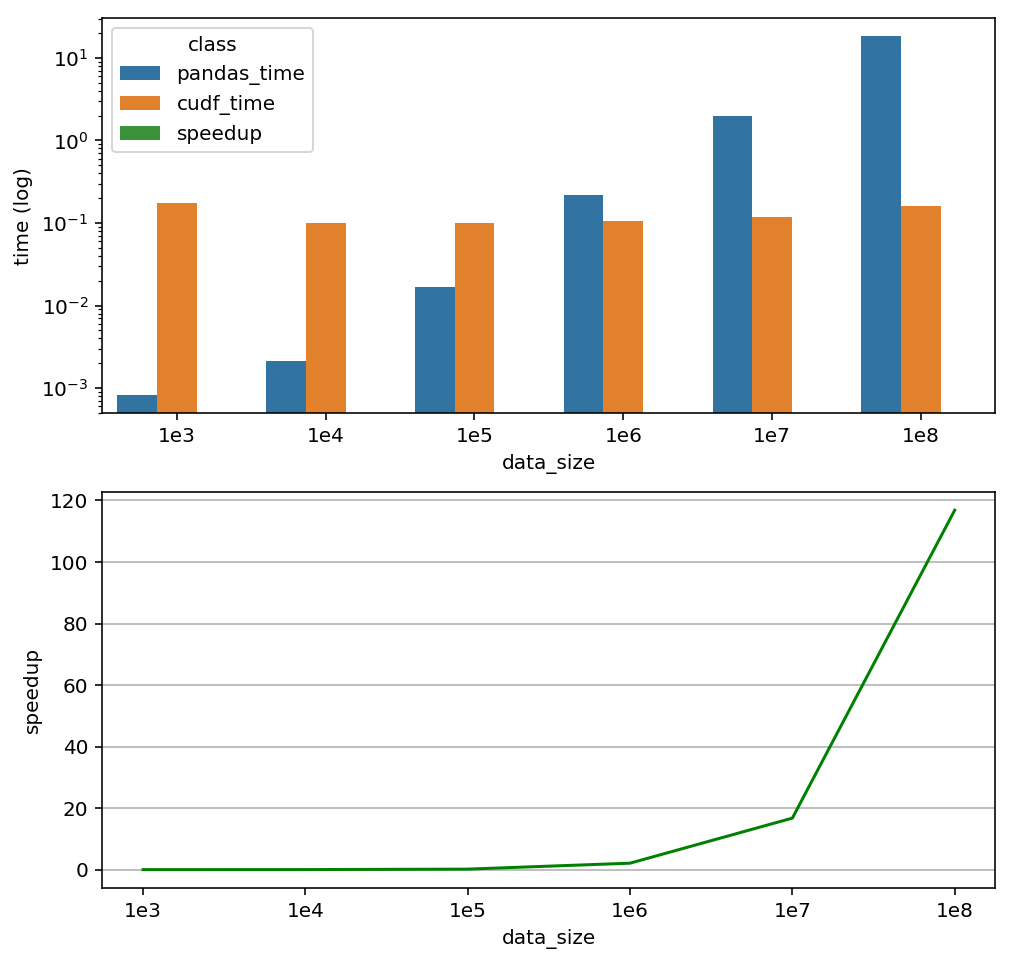

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'
df_time = df[df['class'] != "speedup"]

f, ax = plt.subplots(2, 1, figsize=(8,8))
sns.barplot(x="data_size", y="time", hue="class", data=df_time.to_pandas(), ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_ylabel('time (log)')
sns.lineplot(x="data_size", y="speedup", data=results.to_pandas(), ax=ax[1], color='g')
ax[1].yaxis.grid()